# GHG Emissions using AADT from Satellite Imagery

## Imports

In [64]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import torch
import random
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as album
from PIL import Image
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
import plotly.express as px
import torchmetrics
from torchmetrics import MeanAbsolutePercentageError
from sklearn.preprocessing import robust_scale
import hdbscan
import math


%matplotlib inline

## Global Variables

In [65]:
ROOT_DIR_PATH = os.path.abspath('')
IMAGE_PATH = os.path.join(ROOT_DIR_PATH, "data/example.jpg")
IMAGE_METADATA_PATH = os.path.join(ROOT_DIR_PATH, "data/example_image_metadata.csv") # timestamp, maybe road width, maybe geolocation

In [66]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASS_NAMES = ['road', 'background']
CLASS_RGB_VALUES = [[255,255,255], [0,0,0]]
IMAGE_SIZE = 1024
IMG_SIZE = 1024
PRED_MASK_IMG_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/data/pred_mask.jpeg'

MODEL_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/models/road_extraction_model.pth'
MODEL_STATE_DICT_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/models/road_extraction_state_dict.pth'

# Get RGB values of required classes
SELECT_CLASS_INDICES = [CLASS_NAMES.index(cls.lower()) for cls in CLASS_NAMES]
SELECT_CLASS_RGB_VALUES =  np.array(CLASS_RGB_VALUES)[SELECT_CLASS_INDICES]

In [67]:
ROAD_CHARACTERISTICS_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/data/road_characteristics.csv"

In [ ]:
INFERENCE_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/data/vehicle_counts.csv"

In [101]:
VEHICLE_COUNT_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/data/vehicle_counts.csv'
SPEED_ESTIMATE_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/data/speed_estimate.csv"
ROAD_WIDTH_PATH = ""
IMAGE_METADATA_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/data/image_metadata.csv"

NN_MODEL_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/models/nn_model.pth"
AADT_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/data/aadt.csv"

In [69]:
EMISSIONS_FACTORS_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/data/ground_truth_data/uk_emissions_factors.csv" # emission factor (grams CO2/litre)
SPECIFIC_FUEL_CONSUMPTION_PATH = "/home/ah2719/FYP/Spatial_Finance_Transport/ground_truth_data/fuel_consumption_per_vehicle.csv" # specific fuel consumption per vehicle type A (litres/km)

## General Functions

In [70]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [71]:
# Perform one hot encoding on label (TRAINING ONLY)
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [72]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [73]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(pred_mask, img):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """


    result_img = np.empty(img.shape)

    print("pred_mask shape: {}".format(pred_mask.shape))
    
    for i in range(IMG_SIZE):
        for j in range(IMG_SIZE):
            if np.any(pred_mask[i][j]):
                result_img[i][j] = img[i][j]
            else:
                result_img[i][j] = np.array([0,0,0])
    

    where = np.where(pred_mask == 1)

    print("final result_img shape: {}".format(result_img.shape))
    return result_img

In [74]:
def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [75]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Satellite Image

### Road Extraction
UK shapefile data for training

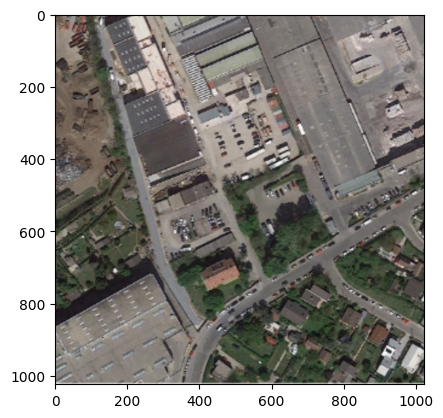

In [76]:
img = cv2.imread(IMAGE_PATH)
img= cv2.resize(img,(IMG_SIZE,IMG_SIZE))
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#show image
plt.imshow(img)

In [77]:
chkpt = torch.load(MODEL_STATE_DICT_PATH)
model = smp.DeepLabV3Plus(
    encoder_name='resnet50', 
    encoder_weights='imagenet', 
    classes=2, 
    activation='sigmoid',
)
model.load_state_dict(chkpt)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [78]:
# preprocessing
img_preprocessed= preprocessing_fn(img)
x_tensor  = to_tensor(img_preprocessed)
x_tensor = torch.from_numpy(x_tensor).unsqueeze(0)
print(x_tensor.shape)

torch.Size([1, 3, 1024, 1024])


pred_mask shape: (1024, 1024)
final result_img shape: (1024, 1024, 3)


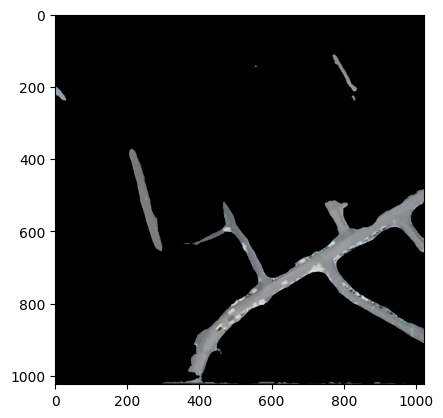

In [79]:
pred_mask = model(x_tensor)
pred_mask = pred_mask.squeeze().detach().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))

pred_mask_reversed = reverse_one_hot(pred_mask)
pred_mask_processed = colour_code_segmentation(pred_mask_reversed, img)

pred_mask_processed = (pred_mask_processed * 255).astype(np.uint8)

# show prediction
plt.imshow(pred_mask_processed)

In [80]:
pred_mask_im = Image.fromarray(pred_mask_processed)
pred_mask_im.save(PRED_MASK_IMG_PATH)

### Road Characteristics

In [81]:
#Read gray image
img = cv2.imread(PRED_MASK_IMG_PATH,0)

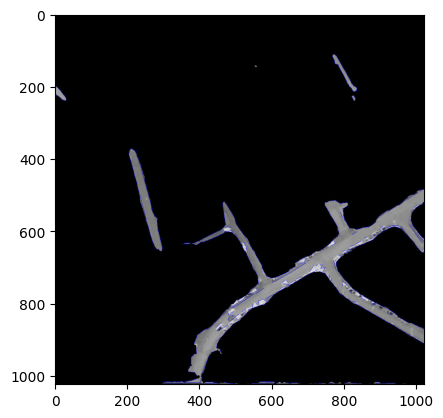

In [82]:
#Create default parametrization LSD
lsd = cv2.createLineSegmentDetector(0)

#Detect lines in the image
lines = lsd.detect(img)[0] #Position 0 of the returned tuple are the detected lines

#Draw detected lines in the image
drawn_img = lsd.drawSegments(img,lines)

#Show image
plt.imshow(drawn_img)

In [83]:
lines = lines.squeeze(1)
print(lines.shape)

(222, 4)


In [84]:
df = pd.DataFrame(lines, columns=list('ABCD'))
plt.rcParams['image.cmap'] = 'Paired'


A = df['A'] #X start
B = df['B'] #Y start
C = df['C'] #X arrive
D = df['D'] #Y arrive
clusterer = hdbscan.HDBSCAN()


df['LENGTH'] = robust_scale(np.sqrt(np.square(df.C-df.A) + np.square(df.D-df.B)))
df['DIRECTION'] = np.arctan2(df.D-df.B, df.C-df.A)
df['COS'] = np.cos(df['DIRECTION'])
df['SIN'] = np.sin(df['DIRECTION'])


columns = ['LENGTH', 'COS', 'SIN']

clusterer = hdbscan.HDBSCAN()
values = df[columns].values
clusterer.fit_predict(values)

cluster_labels = clusterer.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.DataFrame(
        [(values[cluster_labels==n], len(values[cluster_labels==n])) for n in range(num_clusters)],
        columns=["points", "weight"])

df.head()

,A,B,C,D,LENGTH,DIRECTION,COS,SIN
0,534.096130,818.273010,577.802185,802.244690,1.941220,-0.351501,0.938857,-0.344307
1,583.124329,786.873779,728.260559,706.362610,9.183272,-0.506466,0.874464,-0.485090
2,936.874756,586.875671,961.653076,595.047913,0.700371,0.318580,0.949681,0.313218
3,731.365479,712.023560,748.123718,718.128418,0.199718,0.349348,0.939596,0.342285
4,498.194061,605.528992,559.983154,723.461304,7.192157,1.088183,0.464096,0.885785


In [85]:
clusters.head()

,points,weight
0,"[[1.9412197, 0.9388571, -0.34430704], [2.34198...",5
1,"[[0.7003713, 0.94968116, 0.3132183], [0.199717...",184
2,[],0


In [86]:
def get_cmap(n, name='hsv'):
    '''
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.
    
    Credits to @Ali
    https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib#answer-25628397
    '''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(num_clusters+1)
colors = {x:cmap(x) for x in range(num_clusters)}
df['CLUSTER'] = np.nan


for x, (cluster, weight) in enumerate(clusters[clusters.weight>0].values.tolist()):
    df_this_cluster = pd.DataFrame(cluster, columns=columns)
    df_this_cluster['TEMP'] = x
    df = df.merge(df_this_cluster, on=columns, how='left')
    df.reset_index(drop=True, inplace=True)
    
    ix = df[df.TEMP.notnull()].index
    df.loc[ix, "CLUSTER"] = df.loc[ix, "TEMP"]
    df.drop("TEMP", axis=1, inplace=True)
    
df['CLUSTER'] = df['CLUSTER'].fillna(num_clusters-1)
df['COLOR'] = df['CLUSTER'].map(colors)
print("Number of clusters : ", num_clusters-1)

df.head()

Number of clusters :  2


,A,B,C,D,LENGTH,DIRECTION,COS,SIN,CLUSTER,COLOR
0,534.096130,818.273010,577.802185,802.244690,1.941220,-0.351501,0.938857,-0.344307,0.0,"(1.0, 0.0, 0.0, 1.0)"
1,583.124329,786.873779,728.260559,706.362610,9.183272,-0.506466,0.874464,-0.485090,2.0,"(0.0, 0.062501968751969, 1.0, 1.0)"
2,936.874756,586.875671,961.653076,595.047913,0.700371,0.318580,0.949681,0.313218,1.0,"(0.031249343749343732, 1.0, 1.3125013125390552..."
3,731.365479,712.023560,748.123718,718.128418,0.199718,0.349348,0.939596,0.342285,1.0,"(0.031249343749343732, 1.0, 1.3125013125390552..."
4,498.194061,605.528992,559.983154,723.461304,7.192157,1.088183,0.464096,0.885785,2.0,"(0.0, 0.062501968751969, 1.0, 1.0)"


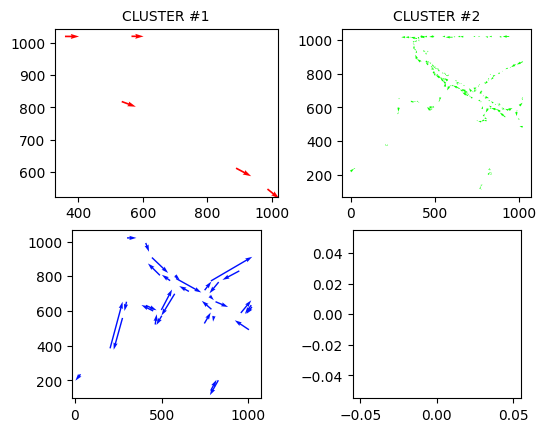

In [87]:
nrows = num_clusters//2 if num_clusters%2==0 else num_clusters//2 + 1
fig,axes = plt.subplots(nrows=nrows, ncols=2)
axes = [y for row in axes for y in row]
for k,ax in enumerate(axes):

    ax.set_aspect('equal', adjustable='box')
    if k+1 <num_clusters:
        ax.set_title(f"CLUSTER #{k+1}", fontsize=10)
    this_df = df[df.CLUSTER==k]
    #print("this_df.A: {}".format(this_df.A))
    #print("this_df.B: {}".format(this_df.B))
    ax.quiver(
        this_df.A, #X
        this_df.B, #Y
        (this_df.C-this_df.A), #X component of vector
        (this_df.D-this_df.B), #Y component of vector
        angles = 'xy', 
        scale_units = 'xy', 
        scale = 1, 
        color=this_df.COLOR
        )

In [88]:
no_of_clusters = df['CLUSTER'].nunique()

double_road_lengths = []
for i in range(1,no_of_clusters):
    double_road_lengths.append(df.loc[df['CLUSTER'] == i, 'LENGTH'].sum())

# Total length of each side of road, therefore need to divide by 2
single_road_lengths = [length / 2 for length in double_road_lengths]

# Take highest length as this is most likely to be length of road segment (others are noise)
road_length = max(single_road_lengths)
road_length

# convert pixel length to Ground Sampling Distance (assume 0.3m)
road_length_gsd_km = road_length * 3e-3
road_length_gsd_km

0.23591894531250002

In [89]:
# Find the midpoint of each cluster - using median value
no_of_clusters = df['CLUSTER'].nunique()


# median cluster values
median_x_start = []
median_y_start = []
median_x_end = []
median_y_end = []
for i in range(1,no_of_clusters):
    median_x_start.append(df.loc[df['CLUSTER'] == i, 'A'].median())
    median_y_start.append(df.loc[df['CLUSTER'] == i, 'B'].median())
    median_x_end.append(df.loc[df['CLUSTER'] == i, 'C'].median())
    median_y_end.append(df.loc[df['CLUSTER'] == i, 'D'].median())


print(median_x_start)
dist_start = []
dist_end = []
# Find distances between clusters
for i in range(len(median_x_start)):
    for j in range(len(median_x_start)):
        dist_start.append(math.dist([median_x_start[i], median_y_start[i]], [median_x_start[j], median_y_start[j]]))
        dist_end.append(math.dist([median_x_end[i], median_y_end[i]], [median_x_end[j], median_y_end[j]]))

road_width = abs(max(dist_end) - max(dist_start))
road_width_gsd_km = road_width * 3e-3
road_width_gsd_km

[661.7393, 583.1243]


0.10414583771737644

In [90]:
df = pd.DataFrame({'road_length_km': [road_length_gsd_km], 'road_width_km': [road_width_gsd_km]})
df.to_csv(ROAD_CHARACTERISTICS_PATH, index=False)

### TODO: Vehicle Detection Inference

In [ ]:
# image
img_path = IMAGE_PATH

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

model

Using cache found in /home/ah2719/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-12 Python-3.8.10 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
# Inference
results = model(img_path)

# Results
results.print()
results.save()  # or .show()

image 1/1: 307x305 1 car
Speed: 200.1ms pre-process, 196.3ms inference, 139.5ms NMS per image at shape (1, 3, 640, 640)
Saved 1 image to runs/detect/exp


In [ ]:
# [0] for firs image
results.pandas().xyxy[0].to_csv(INFERENCE_PATH, index=False)  # img predictions (pandas)

### TODO: Speed Estimate
Questions:
- Why do I need to use PCA based change to identify moving vehicles?
    - Can just do:
        - YOLOv5 inference on MS1 and MS2 images. 
        - Find center of each bounding box.
        - Find distance between adjacent boxes (Assumption: closest bounding boxes represent the same vehicle)
        - Calculate speed = distance / (time between images)

In [92]:
# Expect MS1 and MS2 images
# Need to implement, for now use random value

## AADT 

In [94]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 5),
            nn.Linear(5,20),
            nn.Linear(20,1)
            #nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [95]:
# load model
aadt_model = NeuralNetwork()
aadt_model.state_dict(torch.load(NN_MODEL_PATH))
aadt_model.eval()
aadt_model

/home/ah2719/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1428: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [149]:
# Data should be in form: vehicle_count, avg_mph, day, month, hour, maybe road width, maybe road length (maybes will have to be manually extracted for training)
vehicle_count = torch.tensor([float(len(pd.read_csv(VEHICLE_COUNT_PATH)))]).unsqueeze(-1)
speed_estimate = torch.tensor(pd.read_csv(SPEED_ESTIMATE_PATH)['avg_mph'].values.astype('float32')).unsqueeze(1)
month = torch.tensor(pd.read_csv(IMAGE_METADATA_PATH)['month'].values.astype('float32')).unsqueeze(1)
day = torch.tensor(pd.read_csv(IMAGE_METADATA_PATH)['day'].values.astype('float32')).unsqueeze(1)
hour = torch.tensor(pd.read_csv(IMAGE_METADATA_PATH)['hour'].values.astype('float32')).unsqueeze(1)

In [150]:
x = torch.concat((vehicle_count, speed_estimate, day, month, hour), dim=-1)
aadt = float(aadt_model(x)[0])
df_aadt = pd.DataFrame({'aadt': [aadt]})
df_aadt.to_csv(AADT_PATH, index=False)
aadt

3.1540143489837646

## GHG Emissions

### AADT

In [167]:
df_aadt = pd.read_csv(AADT_PATH)
aadt = df_aadt['aadt']
df_aadt.head()

,aadt
0,3.154014


### Image Metadata

In [168]:
# Each row should represent a detected vehicle
df_vehicle_counts = pd.read_csv(VEHICLE_COUNT_PATH)
df_vehicle_counts.head()

,x_min,y_min,x_max,y_max
0,20,50,25,55
1,23,54,28,59
2,26,58,31,62
3,30,65,38,72


### Road Characteristics

In [169]:
df_road_characteristics = pd.read_csv(ROAD_CHARACTERISTICS_PATH)
df_road_characteristics.head()

,road_length_km,road_width_km
0,0.235919,0.104146


In [170]:
road_segment_length = df_road_characteristics.iloc[0]['road_length_km']
road_segment_length

0.2359189453125

### Emissions Factors

In [171]:
df_emissions_factors = pd.read_csv(EMISSIONS_FACTORS_PATH)
df_emissions_factors['total'] = df_emissions_factors.sum(axis=1)
df_emissions_factors.head() # g/km

/tmp/ipykernel_515/3575893931.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_emissions_factors['total'] = df_emissions_factors.sum(axis=1)


,Vehicle Type,NOx,PM10,PM2.5,CO,VOC,NH3,SO2,Benzene,N2O,total
0,Petrol cars,0.065,0.001,0.001,0.583,0.090,0.013,0.000,0.002,0.001,0.756
1,Diesel cars,0.517,0.008,0.008,0.047,0.004,0.004,0.001,0.000,0.006,0.595
2,Petrol LGVs,0.094,0.001,0.001,1.234,0.085,0.017,0.001,0.002,0.002,1.437
3,Diesel LGVs,0.808,0.007,0.007,0.058,0.008,0.005,0.001,0.000,0.006,0.900
4,Rigid HGVs,1.428,0.020,0.020,0.438,0.039,0.009,0.002,0.000,0.031,1.987


In [172]:
# Average petrol and diesel vehicles
cars_emissions_avg = (df_emissions_factors.iloc[0]['total'] + df_emissions_factors.iloc[1]['total']) / 2
lgv_emissions_avg = (df_emissions_factors.iloc[2]['total'] + df_emissions_factors.iloc[3]['total']) / 2
hgv_bus_emissions_avg = (df_emissions_factors.iloc[4]['total'] + df_emissions_factors.iloc[5]['total'] + df_emissions_factors.iloc[6]['total']) / 3

vehicle_emissions_avg = [cars_emissions_avg, lgv_emissions_avg, hgv_bus_emissions_avg]
vehicle_emissions_avg

[0.6755, 1.1684999999999999, 2.1726666666666663]

### OPTIONAL: Specific Fuel Consumption

In [173]:
#df_specifc_fuel_consumption = pd.read_csv(SPECIFIC_FUEL_CONSUMPTION_PATH)
#df_specifc_fuel_consumption.head()

## Method

### Convert vehicle BB co-ordinates to BB areas

In [174]:
df_vehicle_counts['vehicle_bb_size'] = abs(df_vehicle_counts['x_max'] - df_vehicle_counts['x_min']) * abs((df_vehicle_counts['y_max'] - df_vehicle_counts['y_min']))

# convert to cm (assume GSD 0.3) => 1 pixel represents 30cm
df_vehicle_counts['vehicle_bb_size'] = df_vehicle_counts['vehicle_bb_size'].multiply(30)

df_vehicle_counts

,x_min,y_min,x_max,y_max,vehicle_bb_size
0,20,50,25,55,750
1,23,54,28,59,750
2,26,58,31,62,600
3,30,65,38,72,1680


### Convert vehicle BB area to vehicle type

In [175]:
# highway england dataAPI vehicle sizes in cm
vehicle_sizes = [(0, 660), (661, 1160),	(1161, 2000)]

for j in vehicle_sizes:
        df_vehicle_counts['vehicle_type_{}'.format(j)] = df_vehicle_counts['vehicle_bb_size'].between(j[0], j[1]).astype(int)

df_vehicle_counts

,x_min,y_min,x_max,y_max,vehicle_bb_size,"vehicle_type_(0, 660)","vehicle_type_(661, 1160)","vehicle_type_(1161, 2000)"
0,20,50,25,55,750,0,1,0
1,23,54,28,59,750,0,1,0
2,26,58,31,62,600,1,0,0
3,30,65,38,72,1680,0,0,1


### Set emissions factors from vehicle type

In [177]:
# df_image_metadata['vehicle_type_emissions_factor']  = df_emissions_vehicle_type

df_vehicle_counts['vehicle_type_emissions_avg'] = (df_vehicle_counts['vehicle_type_(0, 660)'] * vehicle_emissions_avg[0]) + (df_vehicle_counts['vehicle_type_(661, 1160)'] * vehicle_emissions_avg[1]) + (df_vehicle_counts['vehicle_type_(1161, 2000)'] * vehicle_emissions_avg[2])
df_vehicle_counts

,x_min,y_min,x_max,y_max,vehicle_bb_size,"vehicle_type_(0, 660)","vehicle_type_(661, 1160)","vehicle_type_(1161, 2000)",vehicle_type_emissions_avg
0,20,50,25,55,750,0,1,0,1.168500
1,23,54,28,59,750,0,1,0,1.168500
2,26,58,31,62,600,1,0,0,0.675500
3,30,65,38,72,1680,0,0,1,2.172667


### Apply portions of aadt estimate to each vehicle

In [195]:
reciprocal_no_of_vehicles = 1 / len(df_vehicle_counts)
aadt_vehicles = (aadt * reciprocal_no_of_vehicles).values[0]

df_vehicle_counts['aadt_vehicles'] = aadt_vehicles
df_vehicle_counts

,x_min,y_min,x_max,y_max,vehicle_bb_size,"vehicle_type_(0, 660)","vehicle_type_(661, 1160)","vehicle_type_(1161, 2000)",vehicle_type_emissions_avg,aadt_vehicles
0,20,50,25,55,750,0,1,0,1.168500,0.788504
1,23,54,28,59,750,0,1,0,1.168500,0.788504
2,26,58,31,62,600,1,0,0,0.675500,0.788504
3,30,65,38,72,1680,0,0,1,2.172667,0.788504


### GHG Emissions calculation

In [197]:
aadt_emissions = 0

for i in range(len(df_vehicle_counts)):
    aadt_emissions += road_segment_length * df_vehicle_counts.iloc[i]['aadt_vehicles'] * df_vehicle_counts.iloc[i]['vehicle_type_emissions_avg']

aadt_emissions

0.9645599201288368

: 

## Questions

### How to choose sites to train DNN on? Could use same sites as Jake to compare results. 

### Could road width be a good alias for road type? This feature may help in DNN predictions. Currently not used.

### How to get MS1, MS2 and Pan Images seperately (MS1 and MS2 required for speed estimation)?
- The paper by Sahi uses PCA, however I think this is due to lack of good object detections as paper was published in 2012
- Propose: replace PCA with DL object detection on MS1 and MS2 then follow Sahi methodology

### Can we automatically extract road segment length? 
Requirements:
- Acceptable trained road extraction model 
- Either: 
    - Image with only one road 
    - Easily distinguishable road segments, and ranking of road lengths (e.g. take longest road segment)